In [7]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from data import LV_dataset
import torch
from torch.utils import data

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
lv = LV_dataset(lv_crop_ratio=1.4, lv_crop_aspect_ratio=0.5)

  0%|          | 0/94 [00:00<?, ?it/s]

Images and masks catalogues are the same.


100%|██████████| 94/94 [00:12<00:00,  7.34it/s]


In [9]:
train_images, train_masks = lv.get_data(subset='train')
valid_images, valid_masks = lv.get_data(subset='test')

100%|██████████| 600/600 [00:00<00:00, 707.44it/s]


In [83]:


# T = transforms.Compose([
#     transforms.Resize([224,224]),
#     transforms.ToTensor(),
# ])

class Dataset(data.Dataset):
    def __init__(self, images, masks):
        self.images = (images / 255 - 0.5).astype(np.float32)
        self.masks = (masks / 255).astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):     
        return self.images[index].transpose(2, 0, 1), self.masks[index].transpose(2, 0, 1)

In [84]:
train_data = Dataset(train_images, train_masks)
valid_data = Dataset(valid_images, valid_masks)

In [85]:
train_data.images.dtype

dtype('float32')

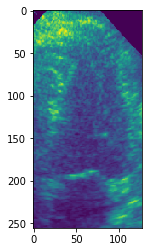

In [86]:
img, msk = train_data[10]
plt.imshow(np.squeeze(img))

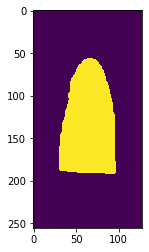

In [87]:
plt.imshow(np.squeeze(msk))

In [88]:
# train_data = Dataset(path, subset='train', transform=T)
# valid_data = Dataset(path, subset='valid', transform=T)
# test_data = Dataset(path, subset='test', transform=T)

In [89]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, 
#                                            batch_size=1, 
#                                            shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [94]:
import segmentation_models_pytorch as smp

model = smp.Unet(in_channels=1).to(device)

Определяем функцию ошибки бинарную кроссэнтропию. Установи шаг обучения для энкодера и декодера сети, причем энкодер будет обучать медленнее.

In [95]:
from torch import nn 

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(),
    smp.utils.metrics.Fscore(),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [96]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [97]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 38/38 [00:00<00:00, 44.08it/s, bce_loss - 0.2901, iou_score - 0.795, fscore - 0.885]  

Epoch: 1
valid: 100%|██████████| 38/38 [00:00<00:00, 44.24it/s, bce_loss - 0.2757, iou_score - 0.8091, fscore - 0.8936]

Epoch: 2
valid: 100%|██████████| 38/38 [00:00<00:00, 44.12it/s, bce_loss - 0.2583, iou_score - 0.8189, fscore - 0.8994]

Epoch: 3
valid: 100%|██████████| 38/38 [00:00<00:00, 44.19it/s, bce_loss - 0.2523, iou_score - 0.8211, fscore - 0.9009]

Epoch: 4
valid: 100%|██████████| 38/38 [00:00<00:00, 43.98it/s, bce_loss - 0.2431, iou_score - 0.8175, fscore - 0.8984]

Epoch: 5
valid: 100%|██████████| 38/38 [00:00<00:00, 44.13it/s, bce_loss - 0.2389, iou_score - 0.834, fscore - 0.9089] 
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 38/38 [00:00<00:00, 44.15it/s, bce_loss - 0.2385, iou_score - 0.8333, fscore - 0.9084]

Epoch: 7
valid: 100%|██████████| 38/38 [00:00<00:00, 44.12it/s, bce_loss - 0.2413, iou_score - 0.8334, fscore - 

error: OpenCV(4.1.2) /io/opencv/modules/dnn/src/dnn.cpp:525: error: (-2:Unspecified error) Can't create layer "404" of type "Cast" in function 'getLayerInstance'


In [24]:
torch.

error: OpenCV(4.1.1) /io/opencv/modules/dnn/src/dnn.cpp:525: error: (-2:Unspecified error) Can't create layer "404" of type "Cast" in function 'getLayerInstance'


In [15]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:01<00:00, 10.34it/s, bce_loss - 0.1875, iou - 0.7847, f-score - 0.8762]


{'bce_loss': 0.1875485456303546,
 'iou': 0.7846613651827763,
 'f-score': 0.8761708956015737}

Максимальное значение на валидации iou метрики - 77% и f-score - 87%. На тесте iou - 77%, f-score - 86%.

Возьмем другую функцию ошибки Dice и построим модель сегментации.

In [16]:
model = smp.Unet().to(device)

loss = smp.utils.losses.BCEDiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [17]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, bce_dice_loss - 1.538, iou - 0.1164, f-score - 0.2084]

Epoch: 1
valid: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s, bce_dice_loss - 1.104, iou - 0.673, f-score - 0.804]  

Epoch: 2
valid: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s, bce_dice_loss - 0.9762, iou - 0.667, f-score - 0.7996]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00, 11.45it/s, bce_dice_loss - 0.9585, iou - 0.5922, f-score - 0.7429]

Epoch: 4
valid: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, bce_dice_loss - 0.9812, iou - 0.4974, f-score - 0.6634]

Epoch: 5
valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, bce_dice_loss - 0.8659, iou - 0.7387, f-score - 0.8496]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s, bce_dice_loss - 0.8687, iou - 0.7287, f-score - 0.8429]

Epoch: 7
valid: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, bce_dice_loss - 0.8698, iou - 0.7313, f-score - 0.8446]

Epoch: 8
v

In [18]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:01<00:00, 14.45it/s, bce_dice_loss - 0.8353, iou - 0.7607, f-score - 0.861] 


{'bce_dice_loss': 0.8353411743515416,
 'iou': 0.7607082504975169,
 'f-score': 0.8609655123007925}

Максимальное значение на валидации iou метрики - 79% и f-score - 88%. На тесте iou - 78%, f-score - 88%.

In [43]:
import torch.nn.functional as F

img, mask_true = test_data[0]
mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


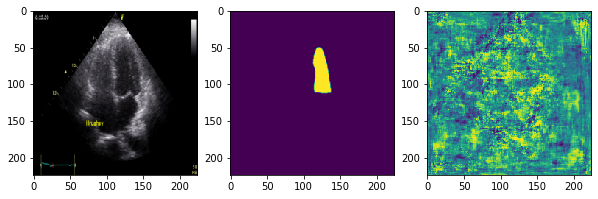

In [44]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy())

In [60]:
import torchsummary
torchsummary.summary(model.decoder, (512, 7, 7), device='cpu')

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 14 and 7 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:689

In [28]:
import torch.onnx as torch_onnx
from torch.autograd import Variable
model.train(False).to('cpu')
model_onnx_path = 'us_segm.onnx'

dummy_input = Variable(torch.randn(1, 3, 224, 224))
output = torch_onnx.export(model, 
                          dummy_input, 
                          model_onnx_path, 
                          verbose=False,
                          opset_version=11)
print("Export of torch_model.onnx complete!")

Export of torch_model.onnx complete!


In [29]:
import cv2
net = cv2.dnn.readNetFromONNX('us_segm.onnx')

error: OpenCV(4.1.1) /io/opencv/modules/dnn/src/dnn.cpp:525: error: (-2:Unspecified error) Can't create layer "404" of type "Cast" in function 'getLayerInstance'


## Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натренируйте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.